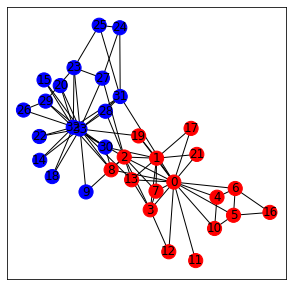

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = nx.karate_club_graph()

pos = nx.spring_layout(G)
color = []
for node in G.nodes:
    if G.nodes[node]['club'] == 'Mr. Hi':
        color.append('r')
    elif G.nodes[node]['club'] == 'Officer':
        color.append('b')

plt.figure(figsize=(5, 5))
#nx.draw(G, pos=pos, node_size=200, node_color=color, with_labels=True)
nx.draw_networkx(G, pos=pos, node_size=200, node_color=color, with_labels=True)

In [0]:
A = nx.adjacency_matrix(G).todense()
L = nx.laplacian_matrix(G).todense()
D = L + A

A_tilde = np.array(A).astype(np.float) + np.identity(G.number_of_nodes(), dtype=np.float)
D_temp = np.array(D).astype(np.float)   # <-- change to D_tilde = D + I

for i in range(G.number_of_nodes()):
  D_temp[i][i] = 1.0 / math.sqrt(D_temp[i][i])

A_hat =  np.matmul(np.matmul(D_temp, A_tilde), D_temp)

X = np.identity(G.number_of_nodes(), dtype=np.float)   

# (*)

y = []
for node in G.nodes:
    if G.nodes[node]['club'] == 'Mr. Hi':
        y.append(0)
    elif G.nodes[node]['club'] == 'Officer':
        y.append(1)


In [3]:
X.shape

(34, 34)

In [4]:
class GCN(nn.Module):
  def __init__(self, A_hat, num_feat, num_hidden, num_class):
    super(GCN, self).__init__()
    self.num_feat = num_feat
    self.num_hidden = num_hidden
    self.num_class = num_class
    self.A_hat = A_hat
    self.W_0 = nn.Parameter(torch.Tensor(num_feat, num_hidden))
    self.W_1 = nn.Parameter(torch.Tensor(num_hidden, num_class))
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.W_0.size(1))
    self.W_0.data.uniform_(-stdv, stdv)
    stdv = 1. / math.sqrt(self.W_1.size(1))
    self.W_1.data.uniform_(-stdv, stdv)

  def forward(self, X, A_hat):
    H = torch.mm(torch.mm(A_hat, X), self.W_0)
    H = F.relu(H)
    H = torch.mm(torch.mm(A_hat, H),self.W_1)
    return F.log_softmax(H, dim=1)

num_feat = len(G.nodes())
num_hidden = 10
num_class = 2

model = GCN(A_hat, num_feat, num_hidden, num_class).to(device)

#for p in model.parameters():
#  print(p.shape)   # 形の確認
#  print(p)   # 初期値の確認

loss_fun = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

#print(optimizer)   # デフォルト値の確認

A_hat_tensor = torch.Tensor(A_hat).to(device)
X_tensor = torch.Tensor(X).to(device)
y_tensor = torch.LongTensor(y).to(device)    

loss_hist = []
acc_hist = []

for epoch in range(500):
  model.train()
  model.zero_grad()

  output = model(X_tensor, A_hat_tensor)
  loss = loss_fun(output, y_tensor)
  loss_hist.append(loss.item())

  preds = torch.argmax(output, dim=1)
  acc = torch.mean(torch.eq(preds, y_tensor).type(torch.DoubleTensor)).numpy()
  acc_hist.append(acc)

  if (epoch+1)%10 == 0:
    print('{}  Loss: {:.4f}  Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

  loss.backward()
  optimizer.step()

10  Loss: 0.6913  Acc: 0.5294
20  Loss: 0.6806  Acc: 0.7353
30  Loss: 0.6699  Acc: 0.7941
40  Loss: 0.6584  Acc: 0.8824
50  Loss: 0.6456  Acc: 0.9412
60  Loss: 0.6307  Acc: 0.9412
70  Loss: 0.6134  Acc: 0.9412
80  Loss: 0.5936  Acc: 0.9412
90  Loss: 0.5708  Acc: 0.9412
100  Loss: 0.5454  Acc: 0.9412
110  Loss: 0.5180  Acc: 0.9412
120  Loss: 0.4897  Acc: 0.9412
130  Loss: 0.4613  Acc: 0.9412
140  Loss: 0.4332  Acc: 0.9412
150  Loss: 0.4058  Acc: 0.9412
160  Loss: 0.3796  Acc: 0.9412
170  Loss: 0.3547  Acc: 0.9412
180  Loss: 0.3315  Acc: 0.9412
190  Loss: 0.3101  Acc: 0.9412
200  Loss: 0.2901  Acc: 0.9412
210  Loss: 0.2717  Acc: 0.9412
220  Loss: 0.2548  Acc: 0.9706
230  Loss: 0.2393  Acc: 0.9706
240  Loss: 0.2252  Acc: 0.9706
250  Loss: 0.2123  Acc: 0.9706
260  Loss: 0.2007  Acc: 0.9706
270  Loss: 0.1902  Acc: 0.9706
280  Loss: 0.1806  Acc: 0.9706
290  Loss: 0.1718  Acc: 0.9706
300  Loss: 0.1638  Acc: 0.9706
310  Loss: 0.1565  Acc: 0.9706
320  Loss: 0.1498  Acc: 0.9706
330  Loss: 0.1437

In [0]:
W_0 = nn.Parameter(torch.Tensor(num_feat, num_hidden))
H = torch.mm(torch.mm(A_hat_tensor, X_tensor), W_0)

In [0]:
lstm = nn.LSTM(num_feat, num_hidden)
input1 = X_tensor.view(len(X_tensor), 1, -1)
out1, out2 = lstm(input1)

In [7]:
out1.shape

torch.Size([34, 1, 10])

In [8]:
H.shape

torch.Size([34, 10])

10  Loss: 0.6870  Acc: 0.5000
20  Loss: 0.6538  Acc: 0.5000
30  Loss: 0.5632  Acc: 0.5588
40  Loss: 0.2943  Acc: 0.8824
50  Loss: 0.1632  Acc: 0.9118
60  Loss: 0.0619  Acc: 1.0000
70  Loss: 0.0088  Acc: 1.0000
80  Loss: 0.0019  Acc: 1.0000
90  Loss: 0.0003  Acc: 1.0000
100  Loss: 0.0002  Acc: 1.0000
110  Loss: 0.0001  Acc: 1.0000
120  Loss: 0.0001  Acc: 1.0000
130  Loss: 0.0001  Acc: 1.0000
140  Loss: 0.0001  Acc: 1.0000
150  Loss: 0.0001  Acc: 1.0000
160  Loss: 0.0001  Acc: 1.0000
170  Loss: 0.0000  Acc: 1.0000
180  Loss: 0.0000  Acc: 1.0000
190  Loss: 0.0000  Acc: 1.0000
200  Loss: 0.0000  Acc: 1.0000
210  Loss: 0.0000  Acc: 1.0000
220  Loss: 0.0000  Acc: 1.0000
230  Loss: 0.0000  Acc: 1.0000
240  Loss: 0.0000  Acc: 1.0000
250  Loss: 0.0000  Acc: 1.0000
260  Loss: 0.0000  Acc: 1.0000
270  Loss: 0.0000  Acc: 1.0000
280  Loss: 0.0000  Acc: 1.0000
290  Loss: 0.0000  Acc: 1.0000
300  Loss: 0.0000  Acc: 1.0000
310  Loss: 0.0000  Acc: 1.0000
320  Loss: 0.0000  Acc: 1.0000
330  Loss: 0.0000

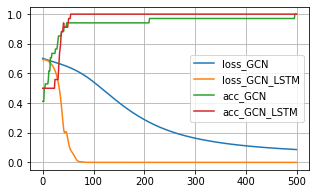

In [9]:
class GCN_LSTM(nn.Module):
  def __init__(self, A_hat, num_feat, num_hidden, num_class):
    super(GCN_LSTM, self).__init__()
    self.num_feat = num_feat
    self.num_hidden = num_hidden
    self.num_class = num_class
    self.A_hat = A_hat
    self.lstm = nn.LSTM(num_feat,num_feat)
    self.W_0 = nn.Parameter(torch.Tensor(num_feat, num_hidden))
    self.W_1 = nn.Parameter(torch.Tensor(num_hidden, num_class))
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.W_0.size(1))
    self.W_0.data.uniform_(-stdv, stdv)
    stdv = 1. / math.sqrt(self.W_1.size(1))
    self.W_1.data.uniform_(-stdv, stdv)

  def forward(self, X, A_hat):
    
    lstm_input1 = X.view(len(X), 1, -1)
    X_out1, X_out2 = self.lstm(lstm_input1)
    X_out1      = X_out1.view(-1, self.num_feat)

    lstm_input2 = A_hat.view(len(A_hat), 1, -1)
    A_out1, A_out2 = self.lstm(lstm_input2)
    A_out1      = A_out1.view(-1, self.num_feat)

    H = torch.mm(torch.mm(A_out1, X_out1), self.W_0)
    H = F.relu(H)
    H = torch.mm(torch.mm(A_out1, H),self.W_1)
    return F.log_softmax(H, dim=1)

num_feat = len(G.nodes())
num_hidden = 10
num_class = 2

model = GCN_LSTM(A_hat, num_feat, num_hidden, num_class).to(device)

#for p in model.parameters():
#  print(p.shape)   # 形の確認
#  print(p)   # 初期値の確認

loss_fun = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

#print(optimizer)   # デフォルト値の確認

A_hat_tensor = torch.Tensor(A_hat).to(device)
X_tensor = torch.Tensor(X).to(device)
y_tensor = torch.LongTensor(y).to(device)    

l_loss_hist = []
l_acc_hist = []

for epoch in range(500):
  model.train()
  model.zero_grad()

  output = model(X_tensor, A_hat_tensor)
  loss = loss_fun(output, y_tensor)
  l_loss_hist.append(loss.item())

  preds = torch.argmax(output, dim=1)
  acc = torch.mean(torch.eq(preds, y_tensor).type(torch.DoubleTensor)).numpy()
  l_acc_hist.append(acc)

  if (epoch+1)%10 == 0:
    print('{}  Loss: {:.4f}  Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

  loss.backward()
  optimizer.step()

#for p in model.parameters():
#  print(p)   # 学習後の値の確認
plt.figure(figsize=(5, 3))
plt.plot(loss_hist, label="loss_GCN")
plt.plot(l_loss_hist, label="loss_GCN_LSTM")
plt.plot(acc_hist, label="acc_GCN")
plt.plot(l_acc_hist, label="acc_GCN_LSTM")
plt.legend()
plt.grid(True)
plt.savefig("GCN_lstm_loss.png")
plt.show()